# Table of Contents

1. [Objective](#1.-Objective)
2. [Imports](#2.-Imports)
3. [EDA](#3.-EDA)
4. [Experiment](#4.-Experiment)
5. [Statistics & Distribution](#5.-Statistics-&-Distribution)
   - [5.1. Bar Plot Distribution](#5.1.-Bar-Plot-Distribution)
   - [5.2. KDE Plot Distribution](#5.2.-KDE-Plot-Distribution)
   - [5.3. Key Statistics](#5.3.-Key-Statistics)
6. [Normality Assumption](#6.-Normality-Assumption)
   - [6.1. Shapiro-Wilk Test](#6.1.-Shapiro-Wilk-Test)
   - [6.2. Standardized Moments](#6.2.-Standardized-Moments)
   - [6.3. Q-Q plot](#6.3.-Q-Q-plot)
7. [Variance Comparing](#7.-Variance-Comparing)
8. [Mann-Whitney U Test](#8.-Mann-Whitney-U-Test)
   - [8.1. Hypotheses](#8.1.-Hypotheses)
   - [8.2. Approach](#8.2.-Approach)
   - [8.3. Statistical Significance](#8.3.-Statistical-Significance)
   - [8.4. Power](#8.4.-Power)
   - [8.5. Effect Size](#8.5.-Effect-Size)
       - [8.5.1. r](#8.5.1.-r)
       - [8.5.2. VDA](#8.5.2.-VDA)
       - [8.5.3. rg](#8.5.3.-rg)
9. [Conclusions](#9.-Conclusions)

To improve code readability, reusability, and maintainability, core logic used in this analysis is implemented outside the notebook in separate Python modules. The notebook focuses on analysis and interpretation of results, while reusable components are encapsulated in a structured package.

```text
project-root/
│
├── datasets/
│   └── ab_revenue_mw1.csv
│
├── notebooks/
│   └── MannWhitneyU_test1.ipynb
│
├── src/
│   ├── __init__.py
│   ├── preprocesser.py
│   ├── core.py
│   ├── config.py
│   └── logic/
│       ├── __init__.py
│       ├── assumptor.py
│       ├── calculator.py
│       ├── plotter.py
│       └── tester.py
```


# 1. Objective

The objective of A/B test is to evaluate whether displaying a discount banner (Treatment Group B) leads to a statistically significant change in revenue per user compared to the standard call-to-action (Control Group A) among users on an e-commerce website. While the dataset is synthetic, it reflects realistic patterns from actual experiment and a specific segment of users behavior. 

# 2. Imports

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parents[0]))

from src.preprocesser import DataGroup
from src.core import SampleDescriber, SampleComparer
import src.config as cfg

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

name = "ab_revenue_mw1.csv"
df = pd.read_csv(cfg.DATA_PATH + name)
df.head()

,user_id,revenue,group
0,196ahica6957x1ee85b44,3.054763,A
1,1914a340d9abx7178500f,0.547230,A
2,198g1981fa79x6f260aa4,4.042339,B
3,195dbbh4ca9bx7c7cea0d,0.762263,A
4,17e35e4e9c79x35d250cb,0.986844,A


# 3. EDA

The UDF below provides a quick overview of the dataset:
- Reports the total number of rows
- Identifies fully duplicated rows
- Checks for duplicate values in specified identifier columns (e.g., 'user_id')
- Summarizes column-level metadata

In [2]:
def explore_dataset(
    in_df:             pd.DataFrame
    , in_ids:          tuple
    , in_types_dict:   dict
    , out_size_text    = "- dataset size"
    , out_dup_text     = "- number of fully duplicated rows"
    , out_missed_text  = "Columns are expected but not found in the dataset: "
)                      -> pd.DataFrame:
    """
    UDF is used for a quick dataset overview for EDA
    """
    print(f"{in_df.shape[0]} {out_size_text}")
    print(f"{in_df.duplicated().sum()} {out_dup_text}")
    
    for ids in in_ids:
        dup_ids = in_df[ids].duplicated().sum()
        if dup_ids > 0:
            print(f"{dup_ids} - number of duplicated {ids}")
        else:
            print(f"No duplicated {ids}")
    
    out_df = pd.DataFrame(in_df.dtypes, columns=["primary_type"])\
                          .reset_index()\
                          .rename(columns={"index": "column"})
    
    out_df["desired_type"]     = out_df["column"].map(in_types_dict)
    out_df['count']            = in_df.count().values
    out_df['null_values']      = in_df.isnull().sum().values
    out_df['unique_values']    = in_df.nunique().values
    
    missing_columns = [col for col in in_types_dict.keys() if col not in in_df.columns]
    if missing_columns:
        print(f"{out_missed_text} {missing_columns}")
    return out_df

explore_dataset(
    in_df = df
    , in_ids = ("user_id",)
    , in_types_dict = {
        "user_id": int
        , "revenue": float
        , "group": str
    }
)

4111 - dataset size
0 - number of fully duplicated rows
No duplicated user_id


,column,primary_type,desired_type,count,null_values,unique_values
0,user_id,object,<class 'int'>,4111,0,4111
1,revenue,float64,<class 'float'>,4111,0,4111
2,group,object,<class 'str'>,4111,0,2


The dataset contains 4 111 records with no fully duplicated rows. The user_id column has no duplicates, confirming that each row represents a unique user. All columns (user_id, revenue, group) are complete, with no missing values.

**The dataset is clean and suitable for A/B test analysis without additional preprocessing.**

## 4. Experiment

Taking into acount all provided above information, following attributes are defined:
- Two independent groups are rewieved.
- Independent (explanatory) variable is nominal (and binary): Control Group A, Treatment Group B.
- Dependant (outcome) variable is scale (continuous): revenue (float type).

Independent two-tailed test should be performed with following hypotheses:

- **Null Hypothesis (H₀):**  
  There is no difference in the distribution of revenue per user between users exposed to the standard CTA (Group A) and those exposed to the discount banner (Group B).

- **Alternative Hypothesis (H₁):**  
  The distribution of revenue per user differs between the two groups.

Statistical parameters: 
- **Alpha = 0.05** (the significance level of a statistical test which represents the probability of making a Type I error)
- **Beta = 0.2** (defining through test power as 1 - beta, reflecting the probability of making a Type II error)

The exact test should be chosen according to parameters of data distribution which is described below.

In [3]:
H0 = "There is no difference in the distribution of two groups" 
H1 = "The distribution of revenue per user differs between the two groups."
data_1 = df[df["group"] == "A"]["revenue"]
data_2 = df[df["group"] == "B"]["revenue"]
label_1 = "Control A"
label_2 = "Treatment B"
color_1 = "yellow"
color_2 = "black"

group1 = [DataGroup(data = data_1, label = label_1, color = color_1)]
group2 = [DataGroup(data = data_2, label = label_2, color = color_2)]
sample_desc1 = SampleDescriber(group1)
sample_desc2 = SampleDescriber(group2)

groups = [
    DataGroup(data = data_1, label = label_1, color = color_1)
    , DataGroup(data = data_2, label = label_2, color = color_2)
]

sample_desc = SampleDescriber(groups)
key_stats = sample_desc.key_stats()
shapiro_wilk = sample_desc.shapiro_wilk_test()
standard_moments = sample_desc.standard_moments()

sample_comp = SampleComparer(groups)
levene = sample_comp.levene_test(center = "median")
mannwhitney_test = sample_comp.mannwhitney_test()

# 5. Statistics & Distribution

The kernel density estimates (KDE) and bar charts show the distribution of revenue per user for the control group (A) and the treatment group (B).

## 5.1. Bar Plot Distribution

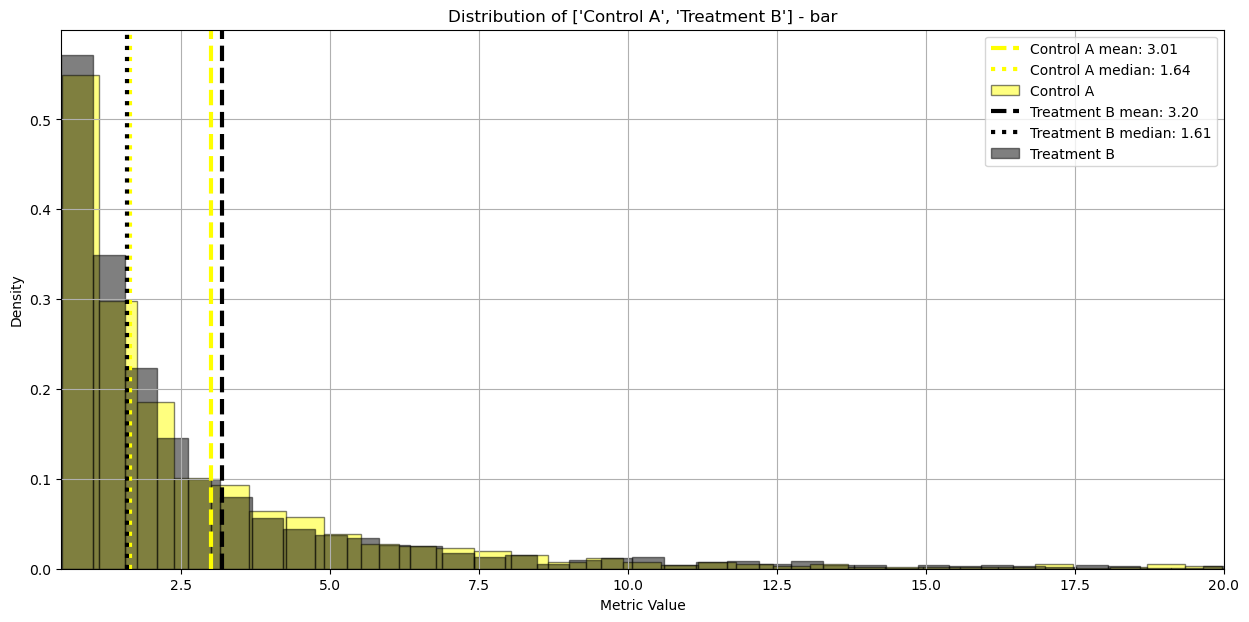

In [4]:
sample_desc.plot_dist(x_max = 20, plot_type = "bar")

## 5.2. KDE Plot Distribution

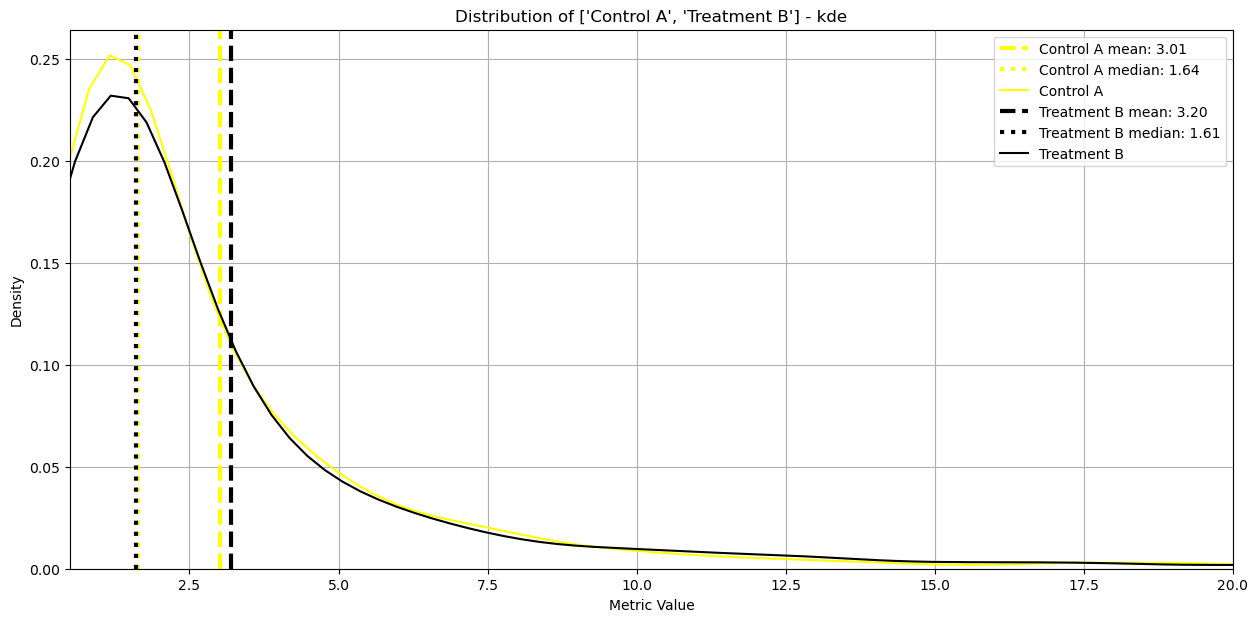

In [5]:
sample_desc.plot_dist(x_max = 20, plot_type = "kde")

Revenue per user is slightly higher in the treatment group (B) than in the control group (A), with comparable sample sizes. Both groups exhibit right-skewed distributions with means exceeding medians.

Based on the KDE plots and summary statistics, revenue per user in both groups appears to follow a non-normal, right-skewed distribution with heavy tails. While it's clear visually, it's still should be measured separately (in the next section).

Full statistics for both groups are below.

## 5.3. Key Statistics

In [6]:
key_stats[label_1]

{'Size': 2028,
 'Total amount': 6094.908807526192,
 'Mean': 3.0053790964133094,
 'Confidence intervals': (2.830707054087386, 3.2076856385379426),
 'Median': 1.6443758630230991,
 'Variation': 18.053684519793425,
 'Standard deviation': 4.248962758108551,
 'Standart error': 0.09435153046810256}

In [7]:
key_stats[label_2]

{'Size': 2083,
 'Total amount': 6658.9055367222845,
 'Mean': 3.1967861434096423,
 'Confidence intervals': (2.989918597788018, 3.415534737121592),
 'Median': 1.6084547546681751,
 'Variation': 24.421116899551148,
 'Standard deviation': 4.9417726474971655,
 'Standart error': 0.10827747666849806}

# 6. Normality Assumption

The choice of statistical test depends on several factors, including the distribution of the data. Below three methods are preformed to evaluate if data is normally distributed.

## 6.1. Shapiro-Wilk Test

The test evaluates whether a sample comes from a normal distribution. 

**Null hypothesis (H₀):**  
$$
H_0: \text{The data comes from a normal distribution}
$$

**Alternative hypothesis (H₁):**  
$$
H_1: \text{The data does not come from a normal distribution}
$$

The test statistic is:

$$
W = \frac{\left(\sum a_i x_i \right)^2}{\sum (x_i - \bar{x})^2}
$$

- $x_i$ are the sorted observations
- $a_i$ are weights based on expected normal order statistics, emphasizing the tails  

For normally distributed data, **$W \approx 1$**. The statistic is converted into a p-value:
- **$p > 0.05$:** data is approximately normal  
- **$p < 0.05$:** data deviates from normality; interpret with respect to sample size  

In [8]:
shapiro_wilk[label_1]

{'H0': 'The sample data is normally distributed.',
 'H1': "The sample data doesn't have normal distribution",
 'w': 0.5289858816080499,
 'p': 7.739531315036066e-59,
 'res': 'Control A: reject H0'}

In [9]:
shapiro_wilk[label_2]

{'H0': 'The sample data is normally distributed.',
 'H1': "The sample data doesn't have normal distribution",
 'w': 0.5060016601526265,
 'p': 3.0201987172285887e-60,
 'res': 'Treatment B: reject H0'}

**For both groups calculated p values are significantly less than 0.05 - there is a sufficient evidence to reject H₀ about normality of distribution.**

However, with large samples, even minor deviations from normality may yield this, that's why 2 more methods are applied.

## 6.2. Standardized Moments

Standardized moments describe the shape of a distribution:

$$
\text{Standardized moment of order k} = \frac{E[(X - \bar{X})^k]}{\text{st\_dev}^k}
$$

Where:

$$
\text{variance} = \frac{\sum (x_i - \bar{x})^2}{n}, \quad
\text{st\_dev} = \sqrt{\text{variance}}
$$

**Skewness and kurtosis** are the 3rd and 4th standardized moments:

$$
g_1 = \frac{\sum (x_i - \bar{x})^3 / n}{\text{st\_dev}^3}, \quad
g_2 = \frac{\sum (x_i - \bar{x})^4 / n}{\text{st\_dev}^4}
$$

In [10]:
print(standard_moments[label_1]["desc"])
print(standard_moments[label_1]["res"])


Control A data has skewness - as g1 should be in (-0.5:0.5) under normality assumption, while g1 = 5.426
Control A data has kurtosis - as g2 should be in (-2:2) under normality assumption, while g2 = 47.254
According to D'Agostino-Pearson test if X2 = Zg1^2 + Zg2^2 > 6, we reject the null hypothesis of normality (as χ²cdf(2, 5.991464546) = 0.95), while X2 = 198636.411

Control A data is NOT normally distributed


In [11]:
print(standard_moments[label_2]["desc"])
print(standard_moments[label_2]["res"])


Treatment B data has skewness - as g1 should be in (-0.5:0.5) under normality assumption, while g1 = 4.845
Treatment B data has kurtosis - as g2 should be in (-2:2) under normality assumption, while g2 = 31.569
According to D'Agostino-Pearson test if X2 = Zg1^2 + Zg2^2 > 6, we reject the null hypothesis of normality (as χ²cdf(2, 5.991464546) = 0.95), while X2 = 94642.094

Treatment B data is NOT normally distributed


**Both groups do not satisfy commonly accepted skewness and kurtosis thresholds under the assumption of normality.**

## 6.3. Q-Q plot

The Q–Q plot compares the empirical quantiles of the data to the theoretical quantiles of a normal distribution. Points close to the diagonal indicate approximate normality, while systematic deviations suggest skewness, heavy tails, or outliers. 

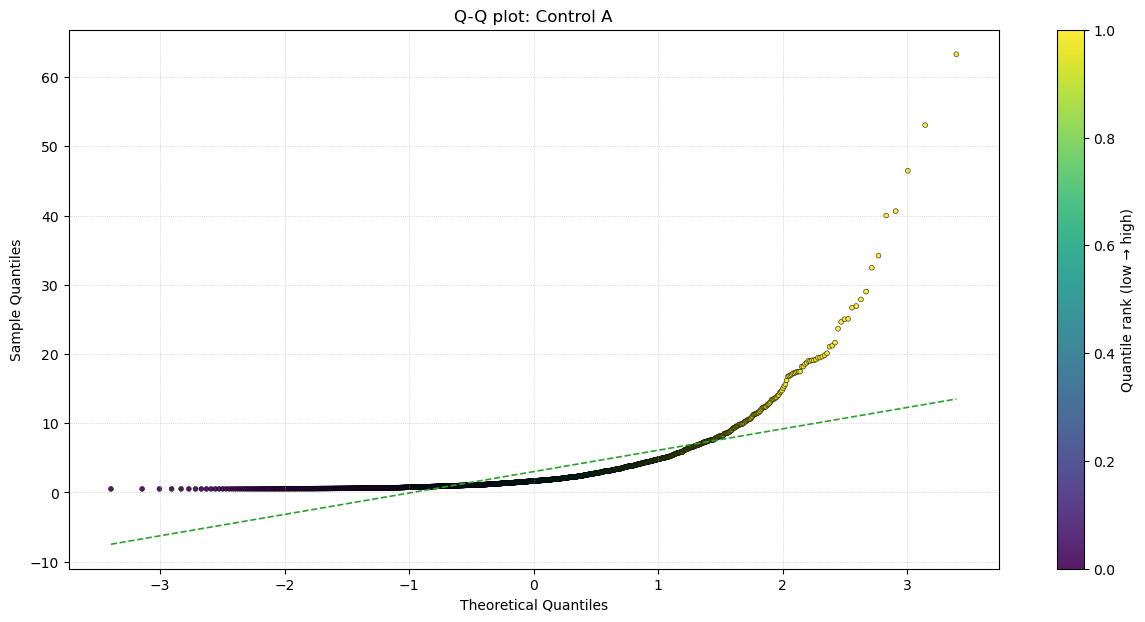

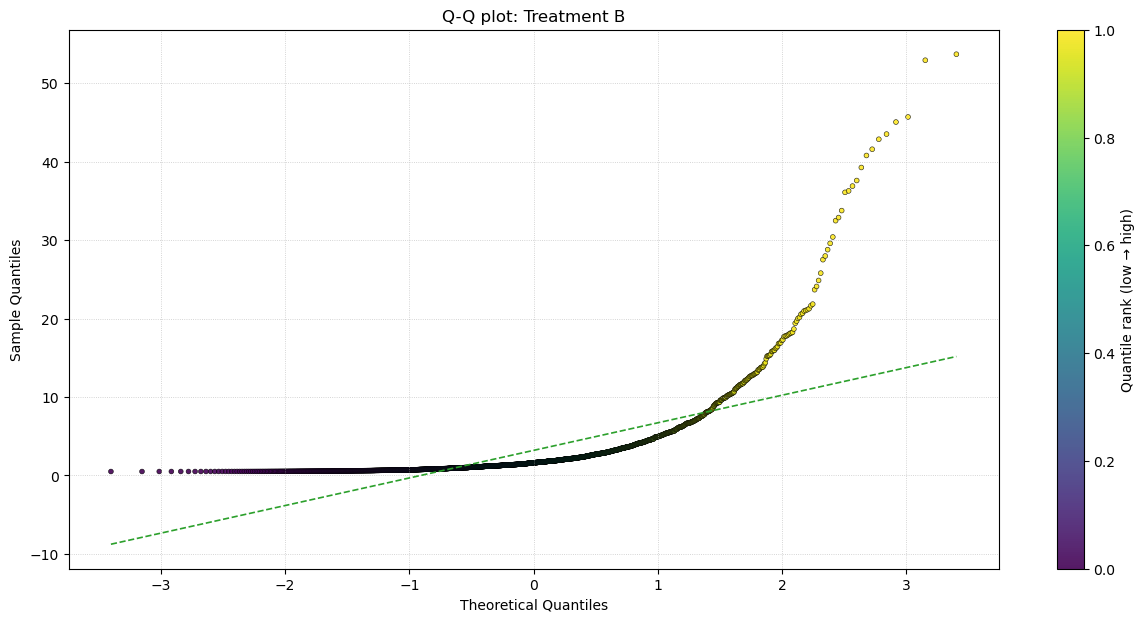

In [12]:
sample_desc.qq_plot()

**In this analysis, the Q–Q plots show that revenue per user does not follow a normal distribution - for each group.**


**All three methods consistently indicate that the data does not follow a normal distribution**.

# 7. Variance Comparing

Levene’s test is used to assess whether multiple groups have equal variances: 
- The test computes the absolute deviations of observations from a group center (mean, median, or trimmed mean).
- An ANOVA is then performed on these deviations.
- Using the median makes Levene’s test more robust to non-normal data.

**Null hypothesis (H₀):** All groups have equal variances.
**Alternative hypothesis (H₁):** At least one group has a different variance.

**Interpretation:**
- **p > 0.05:** Fail to reject \(H_0\); variance homogeneity can be assumed.  
- **p < 0.05:** Reject \(H_0\); variances differ significantly across groups.

In [13]:
levene

{'H0': 'All groups have equal variances.',
 'H1': 'At least one group has a different variance.',
 'p': np.float64(0.12208080287228415),
 'res': 'Fail to reject H0'}

**According to Levene's test, there is no evidence of rejecting null hypothesis about equality of variances** 

Median was used as a group center due to not normal distribution.

# 8. Mann-Whitney U Test

The Mann-Whitney U test - also known as the Wilcoxon-Mann-Whitney test or Wilcoxon rank-sum test - compares the distributions of two independent groups. It is used when the independent variable (i.e., the grouping variable) has two categories. The dependent variable may be either numerical or ordinal in nature.

This test was chosen according to specified above parameters of distribution.

## 8.1. Hypotheses

Rather than comparing means or medians, it evaluates whether observations from one group tend to be larger or smaller than observations from the other group.

$$
P = \Pr(X > Y) + \frac{1}{2}\Pr(X = Y)
$$

where:
- \(X\) is a randomly selected observation from the treatment group  
- \(Y\) is a randomly selected observation from the control group  

**Null hypothesis:**

$$
H_0: P = 0.5
$$

**Alternative hypotheses:**
- Two-sided:  
$$
H_1: P \neq 0.5
$$

- One-sided (treatment improvement):
$$
H_1: P > 0.5
$$

## 8.2. Approach

Consider two independent samples:

X = [85, 70, 90, 88, 65], n₁ = 5  
Y = [60, 75, 80, 95, 78, 82], n₂ = 6  

The Mann-Whitney test works with ranks of values in each sample - combined and sorted values from both samples.

| Value | Group | Rank |
|-------|-------|------|
| 60    | Y     | 1    |
| 65    | X     | 2    |
| 70    | X     | 3    |
| 75    | Y     | 4    |
| 78    | Y     | 5    |
| 80    | Y     | 6    |
| 82    | Y     | 7    |
| 85    | X     | 8    |
| 88    | X     | 9    |
| 90    | X     | 10   |
| 95    | Y     | 11   |

Sum of Ranks:
$$
R_X = 8 + 3 + 10 + 9 + 2 = 32
$$
$$
R_Y = 1 + 4 + 5 + 6 + 7 + 11 = 34
$$

U-Statistics:
$$
U_1 = n_1 n_2 + \frac{n_1 (n_1+1)}{2} - R_X = 13
$$
$$
U_2 = n_1 n_2 + \frac{n_2 (n_2+1)}{2} - R_Y = 17
$$
$$
U_1 + U_2 = n_1 n_2 = 30  
$$
Then test statistic is the smaller of the two
$$
U_{\text{obs}} = \min(U_1, U_2) = 13
$$

Expected U value under $H_0$ (no difference):
$$
E(U) = \frac{n_1 n_2}{2} = 15
$$
Variance:
$$
Var(U) = \frac{n_1 n_2 (n_1+n_2+1)}{12} = 30
$$
Z-score:
$$
Z = \frac{U_{\text{obs}} - E(U)}{\sqrt{Var(U)}} = \frac{13 - 15}{\sqrt{30}} \approx -0.37
$$
p-value:  
- One-sided: $1 - \text{norm.cdf}(|Z|)$  
- Two-sided: $2 \cdot (1 - \text{norm.cdf}(|Z|))$  


# 8.3. Statistical Significance

In [14]:
print(f"""
Null hypothesis H0: {mannwhitney_test["observed"]["H0"]}
Mean difference: {mannwhitney_test["observed"]["mean_diff"]} 
Median difference: {mannwhitney_test["observed"]["median_diff"]}
Observed U: {mannwhitney_test["observed"]["U_obs"]}
Expected U: {mannwhitney_test["observed"]["U_exp"]}
Z-score: {mannwhitney_test["observed"]["Z"]}
p-value: {mannwhitney_test["observed"]["p"]}

Result: {mannwhitney_test["observed"]["res"]}
""")


Null hypothesis H0: The two samples come from the same distribution. Equal medians if samples have the same shape (variance, etc.)
Mean difference: 0.19140704699633293 
Median difference: -0.035921108354924014
Observed U: 2132279.0
Expected U: 2112162.0
Z-score: 0.52874792449678
p-value: 0.5969803269881755

Result: Fail to reject H0



**Here we fail to reject the null hypothesis, and consider two groups came from the same distribution, we don't observe any shift.**

Taking into account the similarity of variances, we can interpretate the hypothesis as comparing of medians - again, there is no statistical evidence to suggest a meaningful difference in median values between the two groups. 

# 8.4. Power

The power of the test is the probability that the test correctly rejects the null hypothesis when the alternative hypothesis is true.

Statistical power represents the probability of detecting a true effect when it exists and helps assess whether the sample size is sufficient for reliable inference. 


The statistical power of the test under the normal approximation is computed as:

$$
\text{Power} =
\Phi\left(\left| z - z_{cr} \right|\right)
+ 1
- \Phi\left(\left| z + z_{cr} \right|\right)
$$

where:
- $\Phi(\cdot)$ is the cumulative distribution function (CDF) of the standard normal distribution  
- $z$ is the standardized test statistic under the alternative hypothesis  
- $z_{cr}$ is the critical value corresponding to the chosen significance level  



In [15]:
mannwhitney_test["observed"]["power"]

0.930226189299323

**The statistical power of the Mann–Whitney U test is high comparing to benchmark (0.8), indicating a strong ability to detect a meaningful difference between the groups if one were present.**

## 8.5. Effect Size

As p-value is heavily dependend on sample size, statistically significant results may correspond to trivial effects, whereas non-significant findings may hide potentially relevant differences. To address these limitations, it is widely recommended that effect sizes be reported alongside p-values.

It especially matters in cases when results are statistically significant but trivial (huge sample, tiny difference) or vice versa not significant but practically important (small sample, large difference).

### 8.5.1. r

$$
r = \frac{z}{\sqrt{n_1 + n_2}}
$$

Following Cohen’s thresholds, the absolute value of r is commonly classified as: 
- small (≥ 0.1)
- medium (≥ 0.3)
- large (≥ 0.5)

Ranges from -1 to 1, with 0 indicating no difference between groups.

In [16]:
mannwhitney_test["observed"]["r"]

0.008246600143598576

### 8.5.2. VDA

Vargha and Delaney’s A (VDA)

$$
\text{VDA} = \frac{U}{n_1 \cdot n_2}
$$

- Small: VDA ≥ 0.56
- Medium: VDA ≥ 0.64
- Large: VDA ≥ 0.71

Ranges from 0 to 1, with 0.5 indicating no difference between groups.

In [17]:
mannwhitney_test["observed"]["vda"]

0.504762182067474

### 8.5.3. rg

Rank-biserial correlation coefficient (rg) = Cliff’s delta (δ)

$$
rg = 1 - \frac{2U}{n_1 \cdot n_2}
$$

- Small: |rg| ≥ 0.11
- Medium: |rg| ≥ 0.28
- Large: |rg| ≥ 0.43

Ranges from -1 to 1, with 0 indicating no difference between groups.

In [18]:
mannwhitney_test["observed"]["rg"]

0.00952436413494806

**All 3 metrics used for calculating effect size show no evidence of any meaningful difference between groups.**

# 9. Conclusions

The treatment group shows a slightly higher mean revenue (+0.19), the median difference is close to zero (−0.04), indicating no meaningful shift in the central tendency.

In [19]:
df_stat = pd.DataFrame(columns = ["metric", label_1, label_2])
df_stat["metric"] = key_stats[label_1].keys()
df_stat[label_1] = key_stats[label_1].values()
df_stat[label_2] = key_stats[label_2].values()
df_stat

,metric,Control A,Treatment B
0,Size,2028,2083
1,Total amount,6094.908808,6658.905537
2,Mean,3.005379,3.196786
3,Confidence intervals,"(2.830707054087386, 3.2076856385379426)","(2.989918597788018, 3.415534737121592)"
4,Median,1.644376,1.608455
5,Variation,18.053685,24.421117
6,Standard deviation,4.248963,4.941773
7,Standart error,0.094352,0.108277


Both control (A) and treatment (B) groups exhibit non-normal revenue distributions, showing significant skewness and kutosis. That could be indicated even visually according to density distribution.

In [20]:
df_moments = pd.DataFrame(columns = ["metric", label_1, label_2, "required"])
df_moments["metric"] = list(standard_moments[label_1].keys())[:5]
df_moments[label_1] = list(standard_moments[label_1].values())[:5]
df_moments[label_2] = list(standard_moments[label_2].values())[:5]
df_moments["required"] = list(standard_moments["required"].values())[:5]
df_moments

,metric,Control A,Treatment B,required
0,g1,5.426222,4.844513,in (-0.5:0.5)
1,Zg1,99.759870,90.264957,None
2,g2,47.254113,31.568563,in (-2:2)
3,Zg2,434.378152,294.099186,None
4,X2,198636.410981,94642.093775,<6


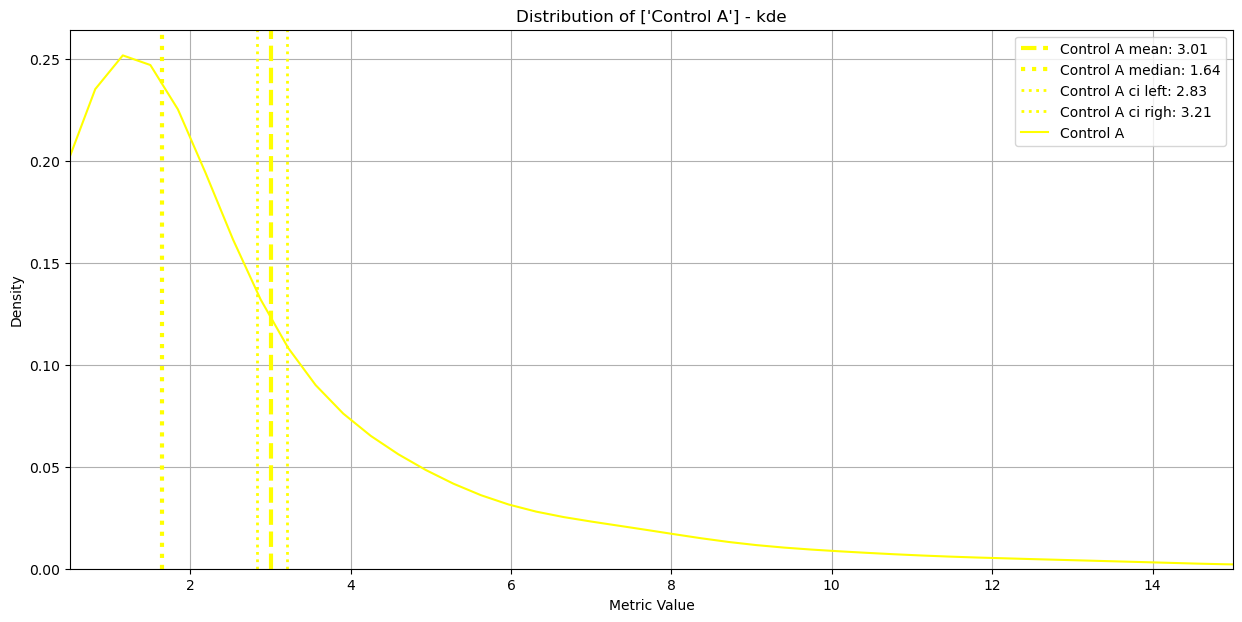

In [21]:
sample_desc1.plot_dist(x_max = 15, plot_type = "kde", show_ci = True)

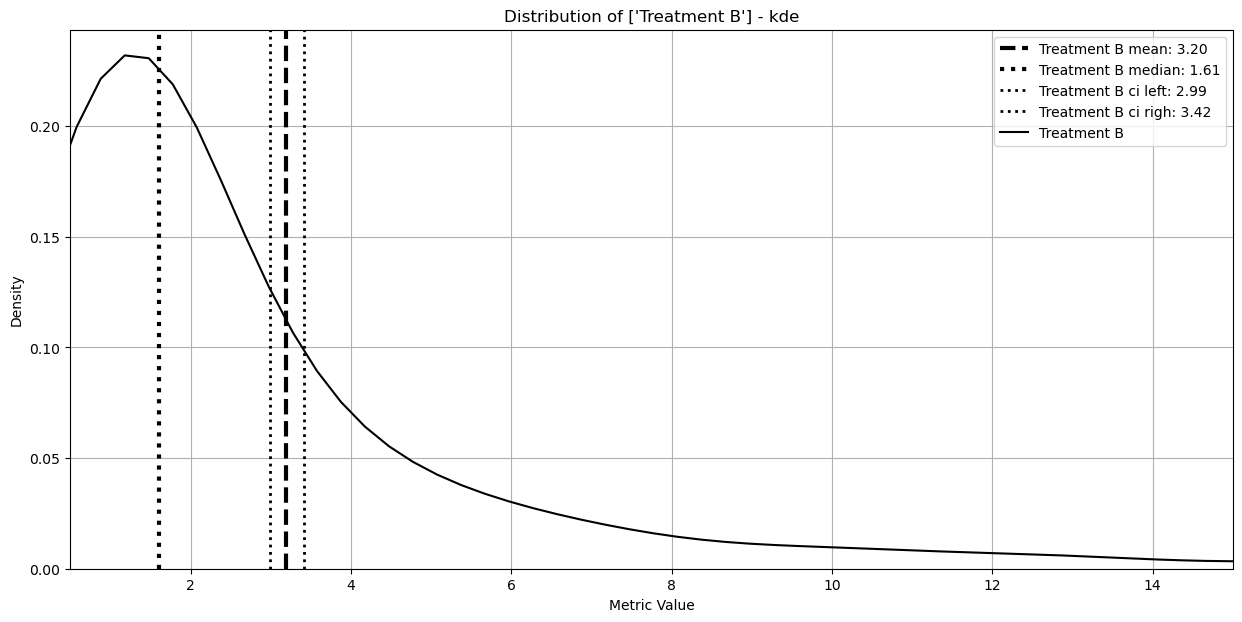

In [22]:
sample_desc2.plot_dist(x_max = 15, plot_type = "kde", show_ci = True)

While sample size is relatively high (2 028 vs 2 083 customers), no statistically significant effect was indicated according to Mann–Whitney U test. The test achieved high statistical power, which indicates there are no reasons to reject the null hypothesis. Effect size measures further support this conclusion and indicate near-complete overlap between the two distributions, with no practical dominance of one group over the other.

In [23]:
print(H0)
df_test = pd.DataFrame(columns = ["metric", "result", "required"])
df_test["metric"] = list(mannwhitney_test["observed"].keys())[4:]
df_test["result"] = list(mannwhitney_test["observed"].values())[4:]
df_test["required"] = list(mannwhitney_test["required"].values())[4:]
df_test

There is no difference in the distribution of two groups


,metric,result,required
0,U_obs,2132279.0,None
1,U_exp,2112162.0,None
2,Variance U,1447535024.0,None
3,Z,0.528748,> |1.960|
4,p,0.59698,< 0.05
5,power,0.930226,> 0.8
6,r,0.008247,"small: > 0.1, medium: > 0.3, large > 0.5"
7,vda,0.504762,"small: > 0.56, medium: > 0.64, large > 0.71"
8,rg,0.009524,"small: > 0.11, medium: > 0.28, large > 0.43"
9,res,Fail to reject H0,None


**Result: Reject null hypothesis.**

**There is no evidence that the discount banner meaningfully impacts user revenue.**

The discount banner did not produce a measurable increase in user revenue compared to the standard call-to-action. Despite sufficient data and high statistical power, user spending behavior remained effectively unchanged between the two variants, suggesting the treatment does not deliver incremental revenue value.

Key suggestion regarding next steps: both distributions are highly skewed, which may mask effects in specific user segments - consider conducting segment-level analysis (e.g., new vs. returning users, high-value users) may have an effect.